In [2]:
# Preparo entorno de ejecucion
import pandas as pd
import numpy as np
import re
import plotly.express as px
# Funciones auxiliares
from script_aux import *
# Configuro display de pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)


# Objetivo Principal
**Limpiar informacion proveniente de la aplicacion properatti**
Se nos presenta un archivo que contienen la informacion sobre imbuebles de distintas regiones de argentina, el objetivo de este desafio es "limpiar" estos datos para posteriormente armar un modelo que permita estimar el precio por metros cuadrados de un nuevo imueble.

Este archivo se le conoce como DataFrame, este tiene diferentes columnas (variables) entre estas son:
- operation: *tipo de operacion*
- property_type: *tipo de propiedad* 
- place_name: *ciudad donde se encuentra*
- place_with_parent_names: *place name, con provincia*
- country_name: *pais donde se ubica*
- state_name: *Proviencia*
- geonames_id: *identificador en sistema de geonames*
- lat-lon: *ubicacion por latitud y longitud*
- lat: *latitud*
- lon: *longitud*
- price: *precio*
- currency: *moneda del precio*
- price_aprox_local_currency: *precio aproximado en moneda local*
- price_aprox_usd: *precio aproximado en dolares*
- surface_total_in_m2: *superficie total en metros cuadrados*
- surface_covered_in_m2: *superfice cubierta*
- price_usd_per_m2: **precio en dolares por metros cuadrados**
- price_per_m2: *precio por metro cuadrados*
- floor: *cantidad de pisos*
- rooms: *habitaciones o ambientes*
- expenses: *precio de expensas*
- properati_url: *url de imueble en properatti*
- description: *descripcion proporcionada*
- title: *titulo proporcionado*
- image_thumbnail: *url a imagen miniatura*

Estos son las diferentes variables que tenemos en el data frame. Muchos de estos campos estan incompletos, nuestro obejetivo sera completarlos para luego discretizar estas varaibles.



### Analisis exploratorio
Antes de armar un modelo de regresion debemos preparar el data set vamos realizar un analsis exploratorio.

Vamos a eliminar columnas que no aportan informacion significativa de forma inmediata
Entre estas tenemos: 
- 'properati_url'
- 'image_thumbnail'
- 'geonames_id'

In [3]:

# Cargo data en data frame
df = pd.read_csv('properatti.csv', index_col=0)
print("Tamanio del data frame: ", df.shape[1], " columnas y ", df.shape[0], " filas \n")

# Eliminamos columnas que no nos interesan
try:
    df.drop(labels=['properati_url', 'image_thumbnail', 'geonames_id'], axis=1, inplace=True)
except:
    print("Ya no hay columnas properati_url, image_thumbnail, geonames_id")
print("Columnas restantes: ", df.shape[1])
for col in df.columns:
    print("->", col)

Tamanio del data frame:  25  columnas y  121220  filas 

Columnas restantes:  22
-> operation
-> property_type
-> place_name
-> place_with_parent_names
-> country_name
-> state_name
-> lat-lon
-> lat
-> lon
-> price
-> currency
-> price_aprox_local_currency
-> price_aprox_usd
-> surface_total_in_m2
-> surface_covered_in_m2
-> price_usd_per_m2
-> price_per_m2
-> floor
-> rooms
-> expenses
-> description
-> title


Vamos a tomar una muestra para comprender el problema

In [4]:
df.sample(1)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
28283,sell,apartment,San Fernando,|Argentina|Bs.As. G.B.A. Zona Norte|San Fernando|,Argentina,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,151000.0,USD,2664319.5,151000.0,73.0,73.0,2068.493151,2068.493151,1.0,NaN,NaN,"Departamento de 3 ambientes con balcÃ³n corrido de 10x1,50 mts - cocina con lavadero (buenos muebles) - living/comedor de buen tamaÃ±o y pisos cerÃ¡micos - dormitorio en suite - otro dormitorio con placard - baÃ±o con ducha.- Caldera central - calefacciÃ³n por tiro balanceado - 3 aires acondicionado tipo splits.- Sin cochera - ARBA $ 780 - Municipal $ 750.- Sujeto a reubicaciÃ³n - se puede alquilar cochera en el edificio.-","Departamento 73m² con Plantas en Peron, Av. Pres. Tte. Gral. J. D. 800, Bs.As. G.B.A. Zona Norte, San Fernando, por U$S 151.000"


Vamos a ver que columnas se encuentran con valores nulos para luego poder completar los mismos con diferentes tecnicas de imputacion

In [5]:
# Extraigo las columnas que tienen valores nulos
df.isnull().sum()

operation                          0
property_type                      0
place_name                        23
place_with_parent_names            0
country_name                       0
state_name                         0
lat-lon                        51550
lat                            51550
lon                            51550
price                          20410
currency                       20411
price_aprox_local_currency     20410
price_aprox_usd                20410
surface_total_in_m2            39328
surface_covered_in_m2          19907
price_usd_per_m2               52603
price_per_m2                   33562
floor                         113321
rooms                          73830
expenses                      106958
description                        2
title                              0
dtype: int64

Podemos ver que los campos `operation`, `property_type`, `place_with_parent_names`, `country_name`, `state_name` y `title` no contien datos nulos.
Vamos a ver que porcentaje de las columnas nulas contienen datos nulos

In [6]:
df_null = df.isnull().sum()
df_null = df_null[df_null > 0]
rows = df.shape[0]
for col in df_null.index:
    por = "{0:.3f}".format((df_null[col]/rows) *100)
    print(f"-> {col} tiene {por} % valores nulos")

-> place_name tiene 0.019 % valores nulos
-> lat-lon tiene 42.526 % valores nulos
-> lat tiene 42.526 % valores nulos
-> lon tiene 42.526 % valores nulos
-> price tiene 16.837 % valores nulos
-> currency tiene 16.838 % valores nulos
-> price_aprox_local_currency tiene 16.837 % valores nulos
-> price_aprox_usd tiene 16.837 % valores nulos
-> surface_total_in_m2 tiene 32.443 % valores nulos
-> surface_covered_in_m2 tiene 16.422 % valores nulos
-> price_usd_per_m2 tiene 43.395 % valores nulos
-> price_per_m2 tiene 27.687 % valores nulos
-> floor tiene 93.484 % valores nulos
-> rooms tiene 60.906 % valores nulos
-> expenses tiene 88.235 % valores nulos
-> description tiene 0.002 % valores nulos


Vamosa imprimir una muestra de cada uno de los campos.

In [7]:
for field in df:
    print(f'{field} : {df[field][np.random.randint(0, df.shape[0])]}')


operation : sell
property_type : house
place_name : Mar del Plata
place_with_parent_names : |Argentina|Buenos Aires Costa Atlántica|Mar del Plata|
country_name : Argentina
state_name : Bs.As. G.B.A. Zona Norte
lat-lon : -34.5300862,-58.7045387
lat : -34.535910986
lon : nan
price : 171181.0
currency : nan
price_aprox_local_currency : 4499347.5
price_aprox_usd : 61692.04
surface_total_in_m2 : 42.0
surface_covered_in_m2 : 96.0
price_usd_per_m2 : nan
price_per_m2 : 2726.027397260274
floor : nan
rooms : nan
expenses : nan
description : Venta de Casa tres ambientes en PH en Castelar con cochera semicubiertaLa propiedad esta compuesta por: living comedor con piso de cerámica rústica;  dos dormitorios, ambos con piso de parquet de pinotea y placares;  baño completo con bañera, piso de cerámica y vanitory (actualizado); cocina comedor con mesada de acero inoxidable, muebles bajo y sobre mesada; patio con piso de baldozones y lavadero semicubierto. En muy buen estado, magnífica ubicación, a una 

## Datos faltantes
Tenemos distintas maneras de tratar los datos faltantes, vamos a ir analizando en cada uno de estas columnas que metodo se ajusta mejor.

### `operation`
El campo `operation` no tiene campos nulos, vamos a ver que valores contiene para ver si nos aporta informacion relevante

In [8]:
df.operation.value_counts()

sell    121220
Name: operation, dtype: int64

Como vemos todos sus campos tienen el mismo valor, "sell" lo que indica que se trarta de una venta. Esto es importante para interpretar el problema de negocio pero no aporta nueva informacion por lo tanto vamos a eliminarla.

In [9]:
try:
    df.drop(labels=['sell'], axis=1, inplace=True)
    print("Se elimino la columna sell")
except:
    print("Ya no hay columnas sell")
print("Columnas totales: ", df.shape[1])

Ya no hay columnas sell
Columnas totales:  22


### `country_name`
El campo `country_name` no tiene valores nulos, veamos que valores contiene:

In [10]:
df.country_name.value_counts()

Argentina    121220
Name: country_name, dtype: int64

Sucede lo mismo que con el campo sell, porocedemos de la misma manera.

In [11]:
try:
    df.drop(labels=['country_name'], axis=1, inplace=True)
    print("Se elimino la columna country_name")
except:
    print("Ya no hay columnas country_name")
print("Columnas totales: ", df.shape[1])

Se elimino la columna country_name
Columnas totales:  21


### `place_name` & `description`
La columna `place_name` con datos nulos representa el 0.019 % y `description` el 0.002% , en este caso vamos a eliminar las filas nulas directamente ya que representan un porcentaje muy bajo de las observaciones.

In [12]:
df.dropna(
    axis=0,
    how='any',
    subset=["description", "place_name"],
    inplace=True
)

print("Datos nulos en description: ", df.description.isnull().sum())
print("Datos nulos en place_name: ", df.place_name.isnull().sum())

Datos nulos en description:  0
Datos nulos en place_name:  0


### `lat-lon`, `lat` & `lon`
Estas columnas estan relacionadas entre si, y contienen la misma informacion.
Para reducir su tamanio vamos eliminar las columnas `lat` y `lon` y nos vamos a quedar solo con `lat-lon`

In [13]:
try:
    df.drop(labels=['lat', 'lon'], axis=1, inplace=True)
    print("Se elimino las columnas lat y lon")
except:
    print("Ya no hay columnas lat y lon")
print("Columnas totales: ", df.shape[1])

Se elimino las columnas lat y lon
Columnas totales:  19


### `currency`
Vamos a intentar completar su valor desde la columna `descripcion` utilizando expresiones regulares, primero vamos a ver que valores contiene

In [14]:
df.currency.value_counts()

USD    87563
ARS    13218
PEN        2
UYU        1
Name: currency, dtype: int64

Vemos que la mayoria de los datos son del tipo **USD** y **ARS**, y solo 3 registros tienen valor **PEN** y **UYU**. Para simplificar las cosas vamos a eliminar estas filas.

In [15]:
mask_PEN = df["currency"] == "PEN"
mask_UYU = df["currency"] == "UYU"
mask = np.logical_or(mask_PEN, mask_UYU)
idx = df.index[mask].to_list()
df.drop(idx, inplace=True)
df.currency.value_counts()

USD    87563
ARS    13218
Name: currency, dtype: int64

Ahora vamos a completar los datos faltantes utilizando la columna `descripcion` y expresiones regulares:

In [16]:
curExp = re.compile(r"(pesos|dolares|USD|U\$D|U\$S)+", re.IGNORECASE| re.MULTILINE) 
print("Datos nulos antes de rellenar 'currency': " +"{0:.4f}".format(showPerOfNull(df.currency, show=False)) + "%")
# Aplico funcion de imputacion
df["currency"] = df.apply(lambda x: inputCurrency(data_row=x, reg_exp=curExp, col_input="description", col_output="currency", reg_exp_group=1), axis=1)
df["currency"] = df.apply(lambda x: inputCurrency(data_row=x, reg_exp=curExp, col_input="title", col_output="currency", reg_exp_group=1), axis=1)

print("Datos nulos despues de rellenar 'currency:'" +"{0:.4f}".format(showPerOfNull(df.currency, show=False)) + "%")

Datos nulos antes de rellenar 'currency': 16.8419%
Datos nulos despues de rellenar 'currency:'13.6214%


In [17]:
df.currency.value_counts()

USD    88852
ARS    15832
Name: currency, dtype: int64

### `rooms`
La columna `rooms` tiene 60.904 % de sus datos nulos

Para poder imputar sus datos vamos a extraerlos a partir de la columna `descripcion` & `title` utilizando expresiones regulares


In [18]:

exp= r"([0-9]|(un|dos|tres|cuatro|cinco|seis|siete|ocho|nueve))+\s(hab|amb|dor|pieza)+"
roomExp =re.compile(exp, re.MULTILINE | re.IGNORECASE)

print("Datos nulos antes de rellenar 'rooms': " +"{0:.4f}".format(showPerOfNull(df.rooms, show=False)) + "%")
# Aplico funcion de imputacion
df["rooms"] = df.apply(lambda x: inputNumber(data_row=x, reg_exp=roomExp, col_input="description", col_output="rooms", reg_exp_group=1), axis=1)
df["rooms"] = df.apply(lambda x: inputNumber(data_row=x, reg_exp=roomExp, col_input="title", col_output="rooms", reg_exp_group=1), axis=1)

print("Datos nulos despues de rellenar 'rooms:'" +"{0:.4f}".format(showPerOfNull(df.rooms, show=False)) + "%")

Datos nulos antes de rellenar 'rooms': 60.9034%
Datos nulos despues de rellenar 'rooms:'15.8575%


Vamos a ver que valores tenemos en almacenados ahora:

In [19]:
df.rooms.value_counts()

2       26206
3       24328
2       11479
4       10913
1        9711
1.0      7406
3        5440
5        2980
4        1297
6         798
5         484
7         325
6.0       180
8          83
7.0        83
0          79
8.0        51
9          44
10.0       28
9.0        18
12.0       10
11.0        7
13.0        6
22.0        4
14.0        2
17.0        2
20.0        2
30.0        2
15.0        1
21.0        1
23.0        1
31.0        1
32.0        1
19.0        1
Name: rooms, dtype: int64

Podemos ver 2 cosas, el tipo de dato de room no es el mismo para todos los casos, y tenemos muchos outliers, por esto vamos a eliminarlos para que no afecte nuestro modelos.

<AxesSubplot:ylabel='Frequency'>

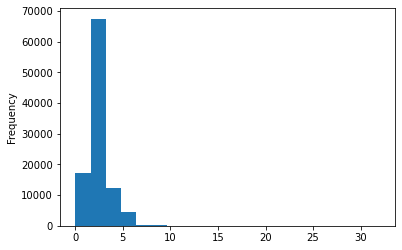

In [20]:
df['rooms'] = df['rooms'].fillna(np.nan).astype(float)

values_before_drop = df.shape[0]
df["rooms"].plot(kind="hist", bins=20)

Ya tenemos los valores de room en tipo `float` , ahora vamos a tratar con los outliers

Vamos a eliminar las obaservaciones con 0 rooms ya que carece de sentido

In [21]:
mask_nulos = df["rooms"] == 0
idx = df.index[mask_nulos].to_list()
df.drop(idx, inplace=True)

Ahora vamos a ver los outliers

In [22]:
mask_GE_7 = df["rooms"] >= 7
per = df["rooms"][mask_GE_7].notna().sum() / df.shape[0]
print(f"Porcentaje de observaciones con rooms mayor o igual a 7: {per:.4f} %")

Porcentaje de observaciones con rooms mayor o igual a 7: 0.0056 %


Podemos ver que estos registros representan el 0.0056% de los datos totales por lo tanto podemos eliminarlos para que no afecten nuestra media

In [23]:
idx = df.index[mask_GE_7].to_list()
df.drop(idx, inplace=True)
df.rooms.value_counts()

2.0    37685
3.0    29768
1.0    17117
4.0    12210
5.0     3464
6.0      978
Name: rooms, dtype: int64

Se eliminaron 752 outliers.
Son 0.0062 % de las observaciones


<AxesSubplot:ylabel='Frequency'>

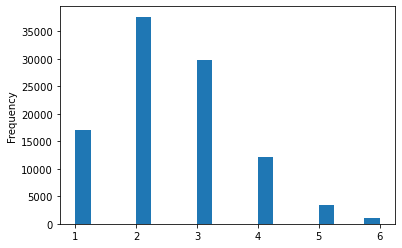

In [24]:
values_after_drop = df.shape[0]
values_diff = values_before_drop - values_after_drop
print(f"Se eliminaron {values_diff} outliers.")
print(f"Son {values_diff/values_before_drop:.4f} % de las observaciones")
df["rooms"].plot(kind="hist", bins=20)